In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import seaborn as sns
import torch
import torch.nn as nn
import random
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import copy

In [2]:
symbol = "PETR4.SA"
start_date = "2023-12-31"
end_date = "2026-01-01"

df_original = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)

df = copy.deepcopy(df_original)

[*********************100%***********************]  1 of 1 completed


In [3]:
df

Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,
2024-01-02,27.692335,27.772964,27.413801,27.443119,24043800
2024-01-03,28.557262,28.674541,27.611706,27.706995,52300200
2024-01-04,28.315380,28.843131,28.227419,28.674543,45344900
2024-01-05,28.381351,28.689206,28.154124,28.491298,35783700
2024-01-08,28.168783,28.168783,27.567732,28.132134,35158100
...,...,...,...,...,...
2025-12-22,30.156794,30.573753,30.156794,30.302244,35896900
2025-12-23,30.309999,30.570000,30.200001,30.549999,35703900


In [4]:
df.tail(1)

Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,
2025-12-30,30.82,30.959999,30.65,30.799999,16880600


In [5]:
# Utilizamos o parâmetro 'B' para considerar apenas dias úteis (Business Days) nos quais 
# a bolsa opera.
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
gaps = full_range.difference(df.index)

print(f"\nTotal de Gaps: {len(gaps)}")
if len(gaps) > 0:
    print("Exemplos de Gaps:", gaps[:3])


Total de Gaps: 20
Exemplos de Gaps: DatetimeIndex(['2024-02-12', '2024-02-13', '2024-03-29'], dtype='datetime64[ns]', freq=None)


In [6]:
# Parece que a maioria (se não 100%) dos gaps são feriados, como ano novo, natal, carnaval, etc.
# Não há gaps inesperados. 
# Podemos prosseguir com o treinamento do modelo.
gaps

DatetimeIndex(['2024-02-12', '2024-02-13', '2024-03-29', '2024-05-01',
               '2024-05-30', '2024-11-15', '2024-11-20', '2024-12-24',
               '2024-12-25', '2024-12-31', '2025-01-01', '2025-03-03',
               '2025-03-04', '2025-04-18', '2025-04-21', '2025-05-01',
               '2025-06-19', '2025-11-20', '2025-12-24', '2025-12-25'],
              dtype='datetime64[ns]', freq=None)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2024-01-02 to 2025-12-30
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, PETR4.SA)   501 non-null    float64
 1   (High, PETR4.SA)    501 non-null    float64
 2   (Low, PETR4.SA)     501 non-null    float64
 3   (Open, PETR4.SA)    501 non-null    float64
 4   (Volume, PETR4.SA)  501 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 39.6 KB


In [8]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,
2024-01-02,27.692335,27.772964,27.413801,27.443119,24043800
2024-01-03,28.557262,28.674541,27.611706,27.706995,52300200
2024-01-04,28.315380,28.843131,28.227419,28.674543,45344900
2024-01-05,28.381351,28.689206,28.154124,28.491298,35783700
2024-01-08,28.168783,28.168783,27.567732,28.132134,35158100


In [9]:
# Remover MultiIndex (se existir) e colocar colunas em lowercase
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0].lower() for col in df.columns]
else:
    df.columns = [c.lower() for c in df.columns]

df

,close,high,low,open,volume
Date,,,,,
2024-01-02,27.692335,27.772964,27.413801,27.443119,24043800
2024-01-03,28.557262,28.674541,27.611706,27.706995,52300200
2024-01-04,28.315380,28.843131,28.227419,28.674543,45344900
2024-01-05,28.381351,28.689206,28.154124,28.491298,35783700
2024-01-08,28.168783,28.168783,27.567732,28.132134,35158100
...,...,...,...,...,...
2025-12-22,30.156794,30.573753,30.156794,30.302244,35896900
2025-12-23,30.309999,30.570000,30.200001,30.549999,35703900
2025-12-26,30.410000,30.430000,30.120001,30.309999,20178600


In [10]:

df["amplitude"] = df["high"] - df["low"]

df["body"] = df["close"] - df["open"]

df["dist_max"] = df["close"] - df["high"]

df["dist_min"] = df["close"] - df["low"]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2024-01-02 to 2025-12-30
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   close      501 non-null    float64
 1   high       501 non-null    float64
 2   low        501 non-null    float64
 3   open       501 non-null    float64
 4   volume     501 non-null    int64  
 5   amplitude  501 non-null    float64
 6   body       501 non-null    float64
 7   dist_max   501 non-null    float64
 8   dist_min   501 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 55.3 KB


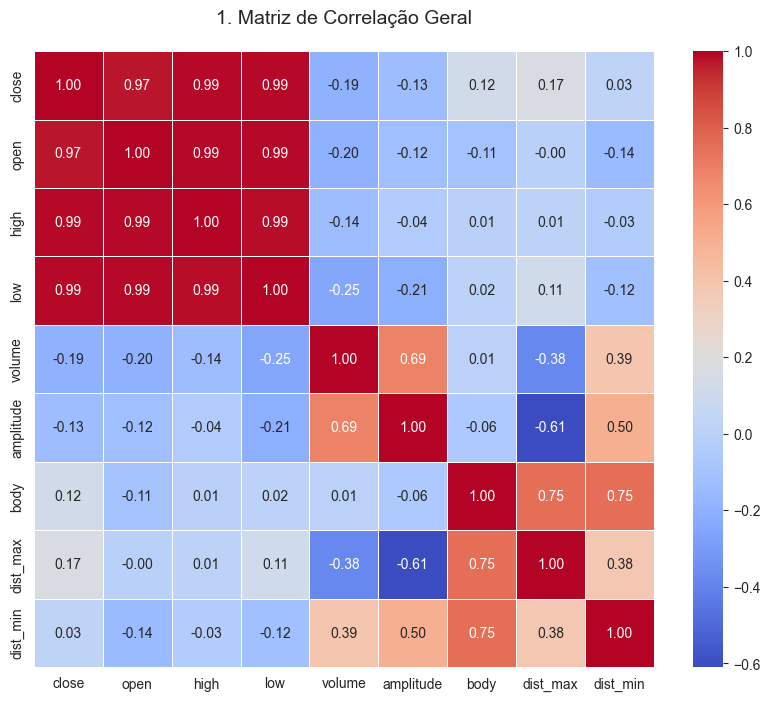

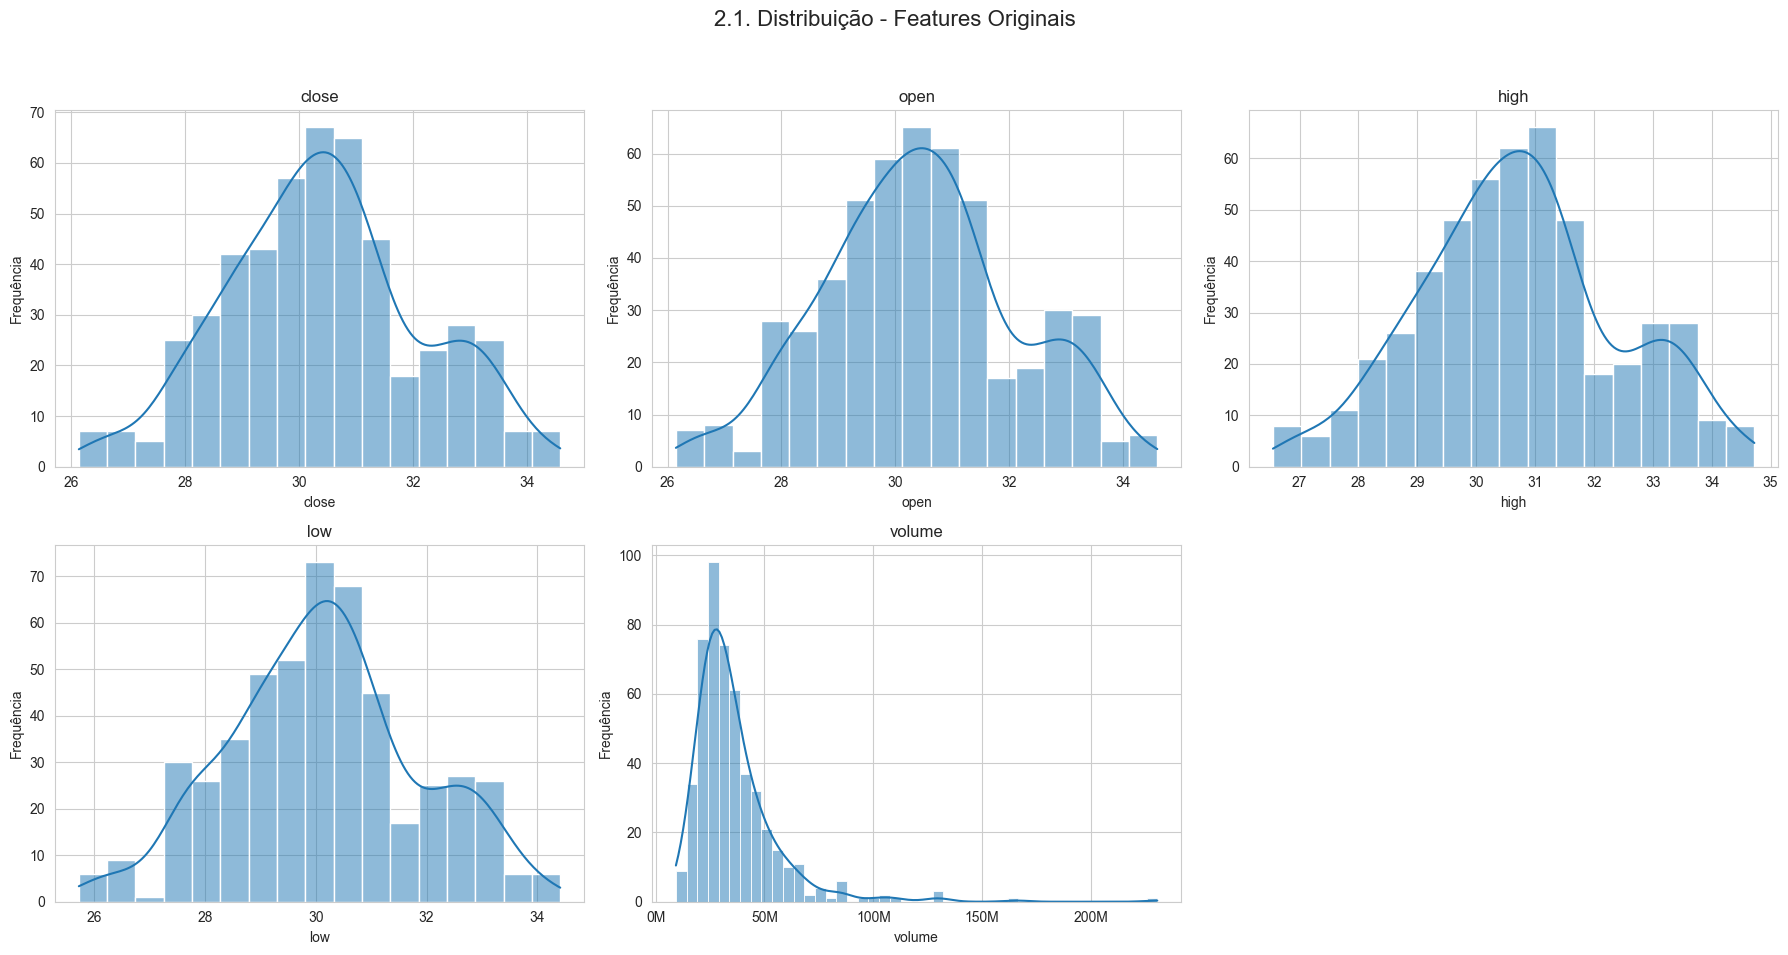

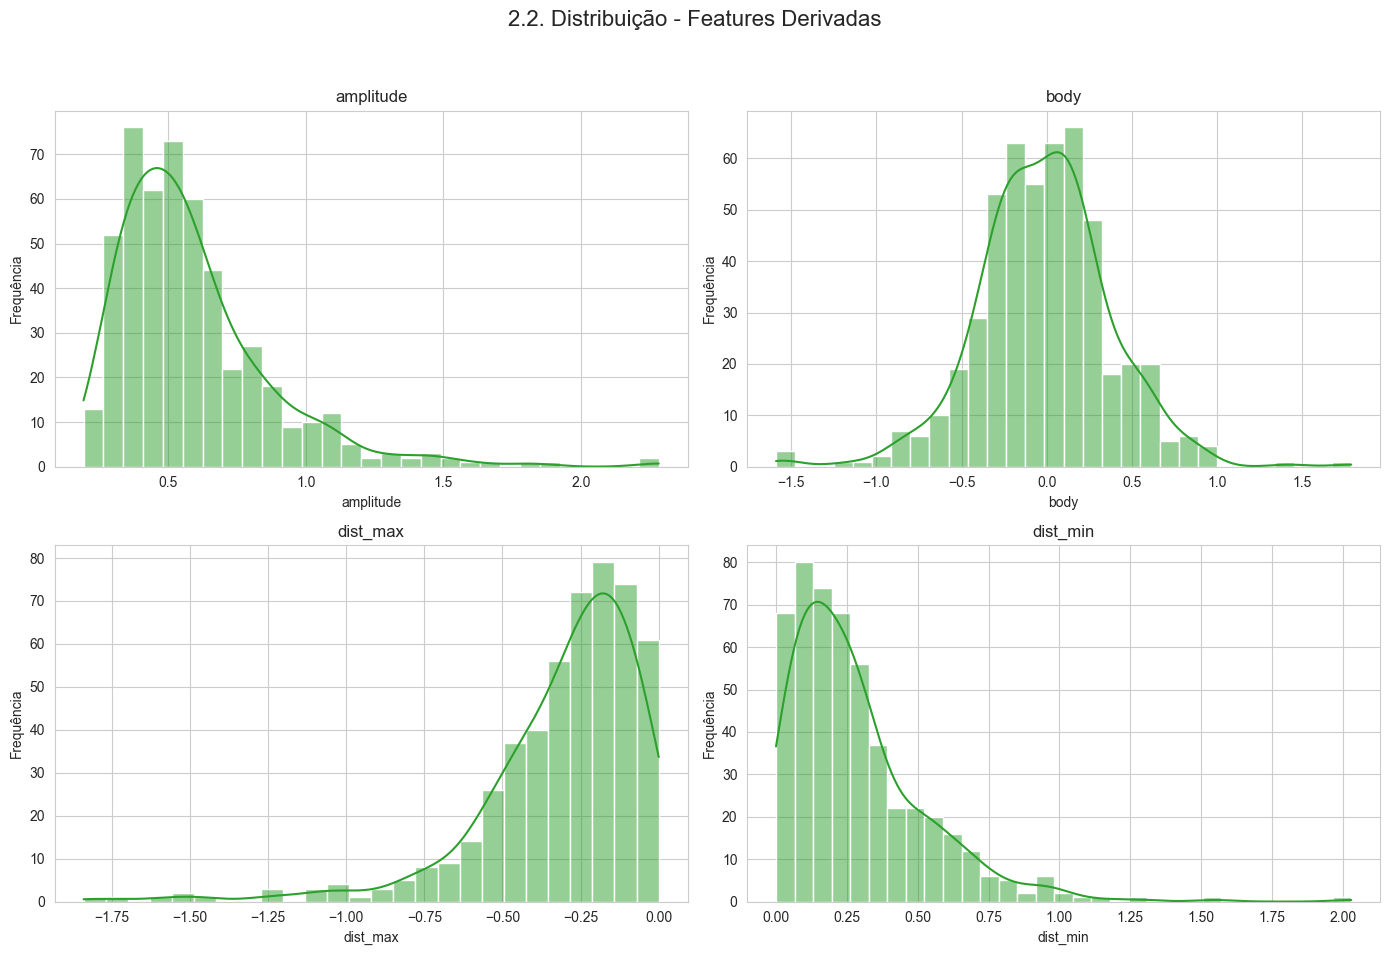

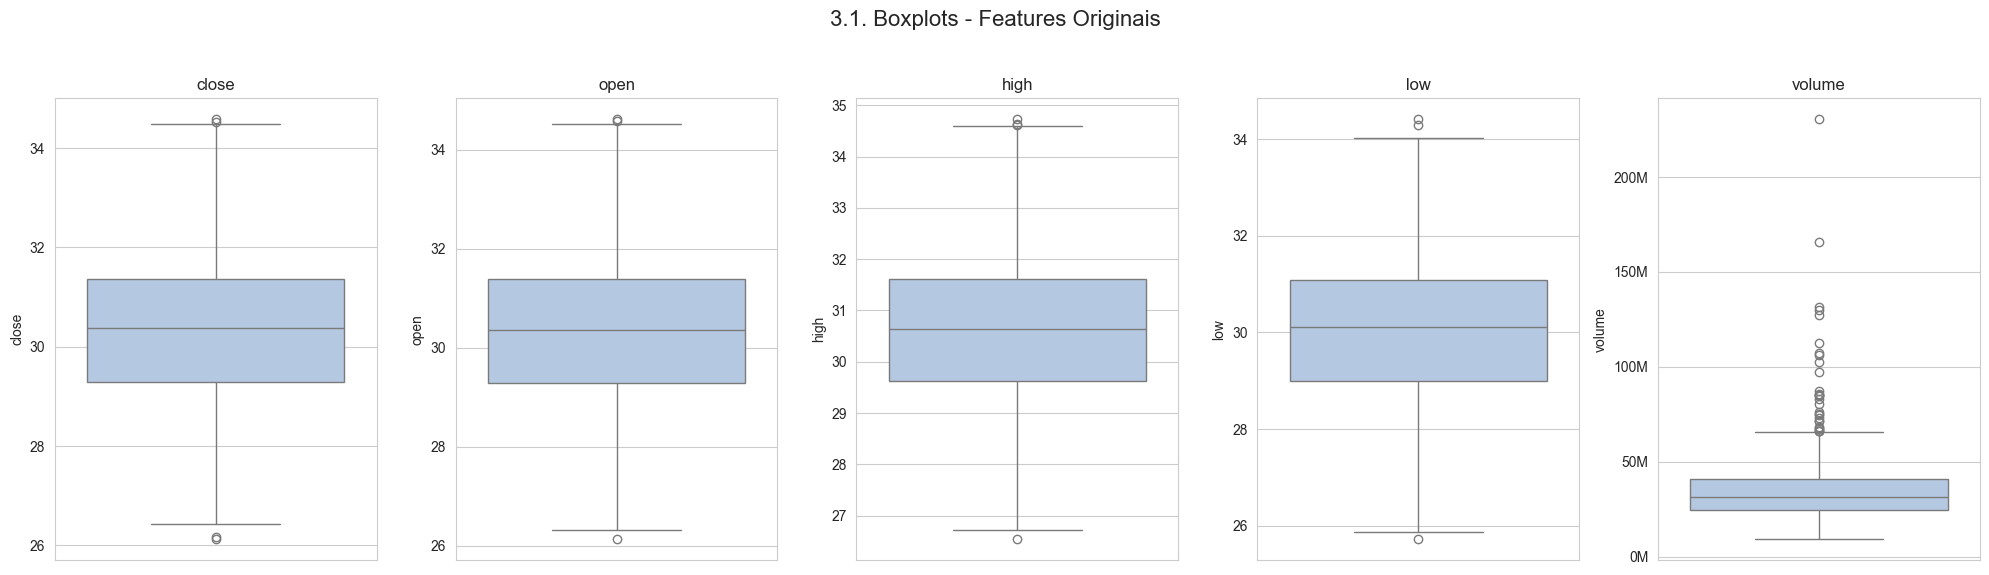

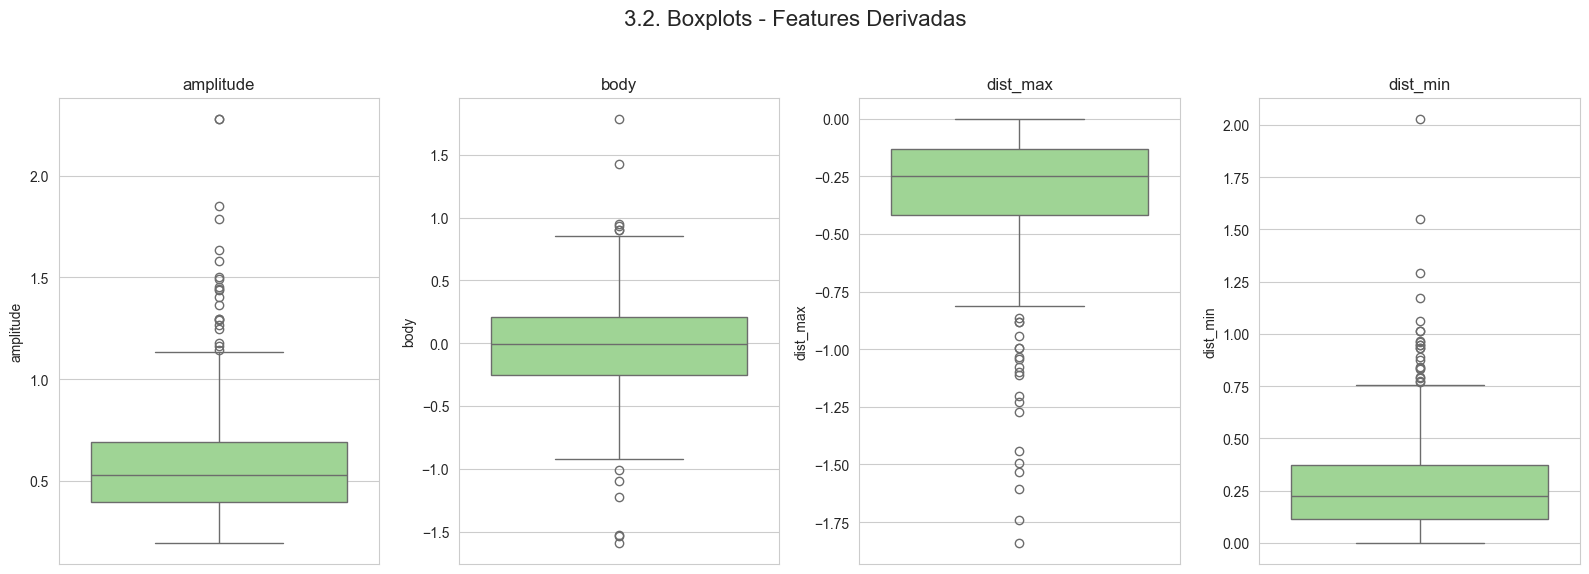

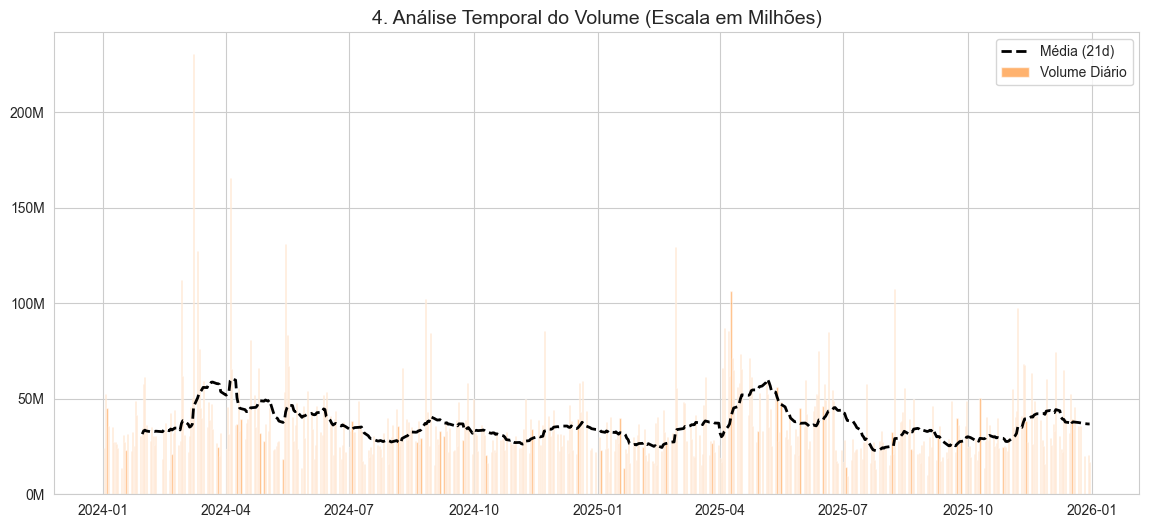

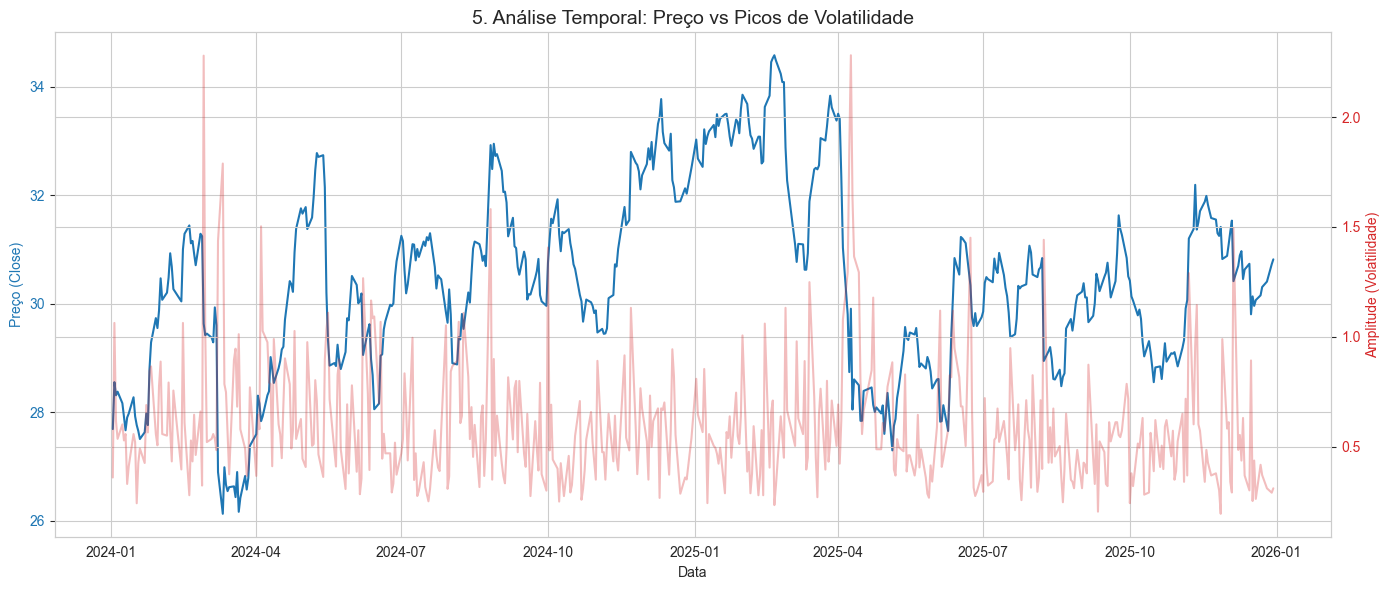

In [12]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Definindo os grupos de features
features_originais = ['close', 'open', 'high', 'low', 'volume']
features_derivadas = ['amplitude', 'body', 'dist_max', 'dist_min']

# Função auxiliar para formatar eixo de Volume (ex: 100M)
def millions_formatter(x, pos):
    return f'{x / 1_000_000:.0f}M'

# --- 1. MATRIZ DE CORRELAÇÃO ---
plt.figure(figsize=(10, 8))
cols_corr = features_originais + features_derivadas
corr_matrix = df[cols_corr].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("1. Matriz de Correlação Geral", fontsize=14, pad=20)
plt.show()

# --- 2. HISTOGRAMAS (Distribuição) ---

# 2.1. Features Originais
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("2.1. Distribuição - Features Originais", fontsize=16)
axes = axes.flatten()

for i, col in enumerate(features_originais):
    sns.histplot(df[col], kde=True, ax=axes[i], color='#1f77b4')
    axes[i].set_title(col)
    axes[i].set_ylabel("Frequência")
    
    # AJUSTE DE VOLUME: Formatação legível no eixo X
    if col == 'volume':
        axes[i].xaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# Remove subplot vazio
if len(features_originais) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2.2. Features Derivadas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("2.2. Distribuição - Features Derivadas", fontsize=16)
axes = axes.flatten()

for i, col in enumerate(features_derivadas):
    sns.histplot(df[col], kde=True, ax=axes[i], color='#2ca02c')
    axes[i].set_title(col)
    axes[i].set_ylabel("Frequência")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 3. BOXPLOTS (Outliers) ---

# 3.1. Features Originais
fig, axes = plt.subplots(1, 5, figsize=(20, 6))
fig.suptitle("3.1. Boxplots - Features Originais", fontsize=16)

for i, col in enumerate(features_originais):
    sns.boxplot(y=df[col], ax=axes[i], color='#aec7e8')
    axes[i].set_title(col)
    
    # AJUSTE DE VOLUME: Formatação legível no eixo Y
    if col == 'volume':
        axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 3.2. Features Derivadas
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
fig.suptitle("3.2. Boxplots - Features Derivadas", fontsize=16)

for i, col in enumerate(features_derivadas):
    sns.boxplot(y=df[col], ax=axes[i], color='#98df8a')
    axes[i].set_title(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 4. VOLUME NO TEMPO (NOVO GRÁFICO) ---
# Adicionado para visualizar a evolução do volume com clareza
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(df.index, df['volume'], color='#ff7f0e', alpha=0.6, label='Volume Diário')
# Média Móvel para tendência
vol_media = df['volume'].rolling(21).mean()
ax.plot(df.index, vol_media, color='black', linewidth=2, linestyle='--', label='Média (21d)')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
ax.set_title("4. Análise Temporal do Volume (Escala em Milhões)", fontsize=14)
ax.legend()
plt.show()

# --- 5. REGIMES DE VOLATILIDADE ---
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Data')
ax1.set_ylabel('Preço (Close)', color=color)
ax1.plot(df.index, df['close'], color=color, label='Preço Fechamento')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Amplitude (Volatilidade)', color=color)  
ax2.plot(df.index, df['amplitude'], color=color, alpha=0.3, label='Amplitude')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("5. Análise Temporal: Preço vs Picos de Volatilidade", fontsize=14)
fig.tight_layout()  
plt.show()

* As variáveis `open`, `high`, `low` e `close` possuem correlação próxima de **1.0**. Isso pode trazer redundancia no modelo. Temos que investigar se é válido adicionar uma ou outra feature para não adicionar ruídos.

* As distribuições de volume e amplitude são fortemente assimétricas à direita. A maior parte dos dias concentra-se em valores baixos a médios, com alguns picos.

* Boxplots de `open` e `close` são quase idênticos. Talvez a combinação Open + Close seja interessante pro modelo.

In [13]:
df_lenght = len(df)
df_lenght

501

In [14]:
def create_sequences(dataset, lookback, target_idx=0):
    """
    Args:
        dataset (np.array): Matriz de dados (Numpy) onde as colunas são as features.
        lookback (int): Tamanho da janela.
        target_idx (int): Índice da coluna que é o alvo (default=0 para 'close' se for a primeira).
    """
    # Se vier DataFrame, converte para Numpy para garantir
    if hasattr(dataset, 'values'):
        data = dataset.values
    else:
        data = dataset

    X, y = [], []
    
    # Loop principal (sua lógica original, mantida)
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback)])
        # Pega o valor do alvo no dia seguinte ao fim da janela
        y.append(data[i + lookback, target_idx]) 
        
    return np.array(X), np.array(y)

def get_dataloaders(df, feature_cols, target_col='close', lookback=30, 
                    split_ratio=0.8, batch_size=32, use_scaler=True):
    """
    Prepara os DataLoaders de treino e teste.
    """
    # 1. Extração dos dados brutos
    data = df[feature_cols].values
    
    # Identificar índice do target dentro da lista de features para o create_sequences
    target_idx = feature_cols.index(target_col)
    
    # 2. Split Cronológico (Antes de escalar para evitar leakage)
    train_size = int(len(data) * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    scaler = None
    
    # 3. Escalonamento Condicional
    if use_scaler:
        scaler = MinMaxScaler()
        # Fit apenas no treino
        train_data = scaler.fit_transform(train_data)
        # Transform no teste (usando estatísticas do treino)
        test_data = scaler.transform(test_data)
        
    # 4. Criar Sequências (usando sua função)
    X_train, y_train = create_sequences(train_data, lookback, target_idx)
    
    # Para o teste, precisamos do final do treino para dar contexto à primeira janela
    # Concatenamos os últimos 'lookback' dias do treino com o teste
    last_window_train = train_data[-lookback:]
    test_data_concat = np.concatenate((last_window_train, test_data))
    
    X_test, y_test = create_sequences(test_data_concat, lookback, target_idx)
    
    # 5. Converter para Tensores
    # X shape: (amostras, lookback, n_features)
    # y shape: (amostras, 1)
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32), 
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
    )
    test_dataset = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32), 
        torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Retornamos o target_idx também para saber qual coluna desnormalizar depois
    return train_loader, test_loader, scaler, target_idx

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.dropout_layer = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1) # Saída única (Preço)

    def forward(self, x):
        # x shape: (batch, lookback, features)
        out, _ = self.lstm(x)
        
        # Pegar apenas o último passo temporal da sequência
        out = out[:, -1, :] 
        
        out = self.dropout_layer(out)
        pred = self.fc(out)
        return pred

In [16]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # para multi-GPU
    
    # Garante que as operações da GPU sejam determinísticas (pode ficar um pouco mais lento)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [17]:
def train_and_evaluate(model, train_loader, test_loader, scaler, target_idx,
                       epochs=100, lr=0.001, patience=15, device='cpu'):
    
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_loss = float('inf')
    patience_counter = 0
    best_weights = copy.deepcopy(model.state_dict())
    
    # --- LOOP DE TREINO ---
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            
        # --- VALIDAÇÃO ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                pred = model(X_val)
                val_loss += criterion(pred, y_val).item()
        
        val_loss /= len(test_loader)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break # Early Stop
    
    # --- AVALIAÇÃO FINAL ---
    model.load_state_dict(best_weights)
    model.eval()
    
    preds_list = []
    targets_list = []
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            pred = model(X_test)
            preds_list.append(pred.cpu().numpy())
            targets_list.append(y_test.numpy())
    
    # Flatten para ficar 1D (N,)
    y_pred = np.concatenate(preds_list).flatten()
    y_true = np.concatenate(targets_list).flatten()
    
    # --- DESNORMALIZAÇÃO UNIVERSAL (CORREÇÃO) ---
    if scaler:
        # 1. Cria uma matriz vazia com o formato que o scaler espera (N_samples, N_features)
        n_features = scaler.n_features_in_
        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_true = np.zeros((len(y_true), n_features))
        
        # 2. Preenche apenas a coluna do Target com nossos valores
        dummy_pred[:, target_idx] = y_pred
        dummy_true[:, target_idx] = y_true
        
        # 3. Faz o inverse_transform da matriz completa
        inv_pred = scaler.inverse_transform(dummy_pred)
        inv_true = scaler.inverse_transform(dummy_true)
        
        # 4. Recupera apenas a coluna que nos interessa
        y_pred_final = inv_pred[:, target_idx]
        y_true_final = inv_true[:, target_idx]
    else:
        y_pred_final = y_pred
        y_true_final = y_true
        
    # Métricas
    rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
    mae = mean_absolute_error(y_true_final, y_pred_final)
    mape = mean_absolute_percentage_error(y_true_final, y_pred_final) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'y_true': y_true_final,
        'y_pred': y_pred_final
    }

In [18]:
# Lista de janelas para testar
janelas_para_testar = [7, 15, 20, 30, 60, 90, 120, 180, 365]

# Dicionário para guardar os datasets prontos
# Estrutura: { 30: {'X': array, 'y': array}, 60: ... }
dados_por_janela = {}

for janela in janelas_para_testar:
    print(f"Processando janela de {janela} dias...")
    
    X_temp, y_temp = create_sequences(df, janela,)
    

    dados_por_janela[janela] = {
        'X': X_temp,
        'y': y_temp
    }
    
    print(f"  -> Concluído. Shape do X: {X_temp.shape}")

Processando janela de 7 dias...
  -> Concluído. Shape do X: (494, 7, 9)
Processando janela de 15 dias...
  -> Concluído. Shape do X: (486, 15, 9)
Processando janela de 20 dias...
  -> Concluído. Shape do X: (481, 20, 9)
Processando janela de 30 dias...
  -> Concluído. Shape do X: (471, 30, 9)
Processando janela de 60 dias...
  -> Concluído. Shape do X: (441, 60, 9)
Processando janela de 90 dias...
  -> Concluído. Shape do X: (411, 90, 9)
Processando janela de 120 dias...
  -> Concluído. Shape do X: (381, 120, 9)
Processando janela de 180 dias...
  -> Concluído. Shape do X: (321, 180, 9)
Processando janela de 365 dias...
  -> Concluído. Shape do X: (136, 365, 9)


In [19]:
resultados = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HIDDEN_SIZE = 50
NUM_LAYERS = 1
DROPOUT = 0.2

EPOCHS = 400        
PATIENCE = 20      
features = ["close"]
opcoes_scaler = [True, False]

In [20]:
# --- 2. LOOP PRINCIPAL (JANELA x SCALER) ---
for janela in janelas_para_testar:
    for usar_scaler in opcoes_scaler:
        
        # Identificador do experimento
        status_scaler = "COM Scaler" if usar_scaler else "SEM Scaler"
        id_exp = f"Win_{janela:03d}_{'S' if usar_scaler else 'N'}"
        
        print(f"\n▶️ Testando: Janela {janela} dias | {status_scaler}...")

        set_seeds(42)
        
        # A) Preparar Dados (Garante Zero Data Leakage)
        train_loader, test_loader, scaler_obj, target_idx = get_dataloaders(
            df, 
            feature_cols=features, 
            target_col='close', 
            lookback=janela, 
            split_ratio=0.8,
            batch_size=32, 
            use_scaler=usar_scaler
        )
        
        # B) Inicializar Modelo
        model = LSTMModel(
            input_size=len(features), # Ajusta input automaticamente
            hidden_size=HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT
        ).to(device)
        
        # C) Treinar e Avaliar
        metrics = train_and_evaluate(
            model, 
            train_loader, 
            test_loader, 
            scaler=scaler_obj, 
            target_idx=target_idx, 
            epochs=EPOCHS, 
            patience=PATIENCE, 
            device=device
        )
        
        # D) Armazenar Resultados
        resultados.append({
            'Janela': janela,
            'Scaler': status_scaler,
            'Features': str(features),
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'MAPE (%)': metrics['MAPE']
        })
        
        print(f"   ✅ Fim. MAPE: {metrics['MAPE']:.4f}% | RMSE: {metrics['RMSE']:.4f}")

# --- 3. RELATÓRIO FINAL ---
print("\n" + "="*60)
print("🏆 RANKING DOS MODELOS")
print("="*60)

df_resultados = pd.DataFrame(resultados)
# Ordenar pelo menor erro percentual (MAPE)
df_resultados = df_resultados.sort_values('MAPE (%)').reset_index(drop=True)

# Formatação para melhor visualização
pd.set_option('display.float_format', '{:.4f}'.format)
display(df_resultados)

# Dica: O melhor modelo estará na primeira linha (índice 0)
melhor_config = df_resultados.iloc[0]
print(f"\n🌟 VENCEDOR: Janela {melhor_config['Janela']} | {melhor_config['Scaler']} | MAPE: {melhor_config['MAPE (%)']:.4f}%")


▶️ Testando: Janela 7 dias | COM Scaler...
   ✅ Fim. MAPE: 0.9371% | RMSE: 0.3955

▶️ Testando: Janela 7 dias | SEM Scaler...
   ✅ Fim. MAPE: 2.6637% | RMSE: 0.9578

▶️ Testando: Janela 15 dias | COM Scaler...
   ✅ Fim. MAPE: 0.9120% | RMSE: 0.3861

▶️ Testando: Janela 15 dias | SEM Scaler...
   ✅ Fim. MAPE: 2.6637% | RMSE: 0.9578

▶️ Testando: Janela 20 dias | COM Scaler...
   ✅ Fim. MAPE: 0.8916% | RMSE: 0.3818

▶️ Testando: Janela 20 dias | SEM Scaler...
   ✅ Fim. MAPE: 2.6638% | RMSE: 0.9578

▶️ Testando: Janela 30 dias | COM Scaler...
   ✅ Fim. MAPE: 0.8979% | RMSE: 0.3821

▶️ Testando: Janela 30 dias | SEM Scaler...
   ✅ Fim. MAPE: 2.6626% | RMSE: 0.9575

▶️ Testando: Janela 60 dias | COM Scaler...
   ✅ Fim. MAPE: 0.9043% | RMSE: 0.3812

▶️ Testando: Janela 60 dias | SEM Scaler...
   ✅ Fim. MAPE: 2.6656% | RMSE: 0.9584

▶️ Testando: Janela 90 dias | COM Scaler...
   ✅ Fim. MAPE: 0.9121% | RMSE: 0.3846

▶️ Testando: Janela 90 dias | SEM Scaler...
   ✅ Fim. MAPE: 2.6656% | RMSE: 0

,Janela,Scaler,Features,RMSE,MAE,MAPE (%)
0,20,COM Scaler,['close'],0.3818,0.2687,0.8916
1,30,COM Scaler,['close'],0.3821,0.2706,0.8979
2,60,COM Scaler,['close'],0.3812,0.2725,0.9043
3,120,COM Scaler,['close'],0.3866,0.2743,0.9099
4,15,COM Scaler,['close'],0.3861,0.2750,0.9120
5,90,COM Scaler,['close'],0.3846,0.2748,0.9121
6,180,COM Scaler,['close'],0.3949,0.2803,0.9286
7,7,COM Scaler,['close'],0.3955,0.2826,0.9371
8,365,COM Scaler,['close'],0.8709,0.7202,2.3964
9,120,SEM Scaler,['close'],0.9571,0.7996,2.6611



🌟 VENCEDOR: Janela 20 | COM Scaler | MAPE: 0.8916%


In [21]:
def avaliar_baseline_naive(df, target_col='close', split_ratio=0.8):
    """
    Cria um baseline simples: Predição(t) = Valor(t-1).
    Avalia exatamente no mesmo conjunto de teste que a LSTM usaria.
    """
    print(f"📉 Calculando Baseline (Naive) para: {target_col}")
    
    # 1. Separar a série completa
    data = df[target_col].values
    
    # 2. Definir o ponto de corte (mesmo split da LSTM)
    split_point = int(len(data) * split_ratio)
    
    # 3. Preparar Teste
    # O "y_true" (Real) são os dados do split em diante
    y_true = data[split_point:]
    
    # O "y_pred" (Previsão) é simplesmente o dia anterior.
    # Para o primeiro dia do teste, usamos o último dia do treino.
    # Para os demais, usamos o dia anterior do próprio teste.
    # Truque do Numpy: Pegamos toda a série deslocada e cortamos no split
    y_pred = df[target_col].shift(1).values[split_point:]
    
    # 4. Calcular Métricas
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'Modelo': 'Baseline (Naive)',
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape
    }

# --- EXECUÇÃO ---

# Calcula
metrics_baseline = avaliar_baseline_naive(df, target_col='close', split_ratio=0.8)

# Exibe
print("\n" + "="*40)
print("🛡️ BARRA DE REFERÊNCIA (BASELINE)")
print("="*40)
df_base = pd.DataFrame([metrics_baseline])
pd.set_option('display.float_format', '{:.4f}'.format)
display(df_base)

print(f"\n⚠️ DESAFIO: Sua LSTM precisa ter um MAPE menor que {metrics_baseline['MAPE (%)']:.4f}% para valer a pena.")

📉 Calculando Baseline (Naive) para: close

🛡️ BARRA DE REFERÊNCIA (BASELINE)


,Modelo,RMSE,MAE,MAPE (%)
0,Baseline (Naive),0.3878,0.2763,0.9165



⚠️ DESAFIO: Sua LSTM precisa ter um MAPE menor que 0.9165% para valer a pena.


In [22]:
dados_por_feature = {}

features_set = {
    "1": ["close"], 
    "2": ["close", "open"],
    "3": ["close", "low"],
    "4": ["close", "high"],
    "5": ["close", "volume"],
    "6": ["close", "open", "low", "high"],
    "7": ["close", "open", "low", "high", "volume"],
    "8": ["close", "amplitude"],
    "9": ["close", "amplitude", "volume"],
    "10": ["close", "amplitude", "body", "dist_max", "dist_min"],
    "11": ["close", "body", "dist_max", "dist_min"],
    "12": ["close",  "dist_max", "dist_min"],
}


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


BEST_WINDOW = 20
USE_SCALER = True 
HIDDEN_SIZE = 50  
EPOCHS = 400      
PATIENCE = 20 

# Seu dicionário de features
features_set = {
    "1": ["close"], 
    "2": ["close", "open"],
    "3": ["close", "low"],
    "4": ["close", "high"],
    "5": ["close", "volume"],
    "6": ["close", "open", "low", "high"],
    "7": ["close", "open", "low", "high", "volume"],
    "8": ["close", "amplitude"],
    "9": ["close", "amplitude", "volume"],
    "10": ["close", "amplitude", "body", "dist_max", "dist_min"],
    "11": ["close", "body", "dist_max", "dist_min"],
    "12": ["close",  "dist_max", "dist_min"],
}

resultados_features = []

print("🚀 INICIANDO BATTLE ROYALE DE FEATURES")
print(f"⚙️ Config: Janela {BEST_WINDOW} | Scaler: {USE_SCALER} | Device: {device}")
print("="*70)

# --- 2. LOOP DE TESTES ---
for feat_id, cols in features_set.items():
    
    # Verifica se as colunas existem no DF para evitar crash
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"⚠️ Pular Set {feat_id}: Colunas ausentes no DF -> {missing}")
        continue

    print(f"\n▶️ Testando Set {feat_id} (Num Features: {len(cols)})...")
    # print(f"   Cols: {cols}") # Descomente se quiser ver a lista completa no log


    set_seeds(42)
    # A) Preparar Dados (Modularizado)
    # Note: target_col='close' garante que o alvo seja sempre o Close, 
    # independente das features de entrada.
    train_loader, test_loader, scaler_obj, target_idx = get_dataloaders(
        df, 
        feature_cols=cols, 
        target_col='close', 
        lookback=BEST_WINDOW, 
        split_ratio=0.8,
        batch_size=32, 
        use_scaler=USE_SCALER
    )
    
    # B) Inicializar Modelo
    # input_size se adapta dinamicamente ao tamanho da lista 'cols'
    model = LSTMModel(
        input_size=len(cols), 
        hidden_size=HIDDEN_SIZE, 
        num_layers=1, 
        dropout=0.2
    ).to(device)
    
    # C) Treinar e Avaliar
    metrics = train_and_evaluate(
        model, 
        train_loader, 
        test_loader, 
        scaler=scaler_obj, 
        target_idx=target_idx, 
        epochs=EPOCHS, 
        patience=PATIENCE, 
        device=device
    )
    
    # D) Armazenar
    resultados_features.append({
        'ID': feat_id,
        'Num Features': len(cols),
        'Features': str(cols), 
        'RMSE': metrics['RMSE'],
        'MAE': metrics['MAE'],
        'MAPE (%)': metrics['MAPE']
    })
    
    print(f"   ✅ Resultado: MAPE = {metrics['MAPE']:.4f}%")

# --- 3. RELATÓRIO FINAL ---
print("\n" + "="*70)
print("🏆 RANKING DE FEATURES")
print("="*70)

df_feat_results = pd.DataFrame(resultados_features)
# Ordena pelo menor erro (MAPE)
df_feat_results = df_feat_results.sort_values('MAPE (%)').reset_index(drop=True)

pd.set_option('display.max_colwidth', 100) # Para ver as listas de features inteiras
pd.set_option('display.float_format', '{:.4f}'.format)

display(df_feat_results[['ID', 'MAPE (%)', 'RMSE', 'MAE', 'Features']])

# Destaque do Vencedor
melhor = df_feat_results.iloc[0]
print(f"\n🌟 MELHOR CONJUNTO: ID {melhor['ID']} com MAPE {melhor['MAPE (%)']:.4f}%")

🚀 INICIANDO BATTLE ROYALE DE FEATURES
⚙️ Config: Janela 20 | Scaler: True | Device: cpu

▶️ Testando Set 1 (Num Features: 1)...
   ✅ Resultado: MAPE = 0.8916%

▶️ Testando Set 2 (Num Features: 2)...
   ✅ Resultado: MAPE = 0.8902%

▶️ Testando Set 3 (Num Features: 2)...
   ✅ Resultado: MAPE = 0.9370%

▶️ Testando Set 4 (Num Features: 2)...
   ✅ Resultado: MAPE = 0.8958%

▶️ Testando Set 5 (Num Features: 2)...
   ✅ Resultado: MAPE = 0.9578%

▶️ Testando Set 6 (Num Features: 4)...
   ✅ Resultado: MAPE = 0.8904%

▶️ Testando Set 7 (Num Features: 5)...
   ✅ Resultado: MAPE = 0.9419%

▶️ Testando Set 8 (Num Features: 2)...
   ✅ Resultado: MAPE = 0.9076%

▶️ Testando Set 9 (Num Features: 3)...
   ✅ Resultado: MAPE = 0.9548%

▶️ Testando Set 10 (Num Features: 5)...
   ✅ Resultado: MAPE = 0.9369%

▶️ Testando Set 11 (Num Features: 4)...
   ✅ Resultado: MAPE = 0.9451%

▶️ Testando Set 12 (Num Features: 3)...
   ✅ Resultado: MAPE = 0.9093%

🏆 RANKING DE FEATURES


,ID,MAPE (%),RMSE,MAE,Features
0,2,0.8902,0.3876,0.2681,"['close', 'open']"
1,6,0.8904,0.3937,0.2681,"['close', 'open', 'low', 'high']"
2,1,0.8916,0.3818,0.2687,['close']
3,4,0.8958,0.3882,0.2698,"['close', 'high']"
4,8,0.9076,0.3841,0.2736,"['close', 'amplitude']"
5,12,0.9093,0.3843,0.2745,"['close', 'dist_max', 'dist_min']"
6,10,0.9369,0.3934,0.2821,"['close', 'amplitude', 'body', 'dist_max', 'dist_min']"
7,3,0.9370,0.3967,0.2825,"['close', 'low']"
8,7,0.9419,0.4086,0.2836,"['close', 'open', 'low', 'high', 'volume']"
9,11,0.9451,0.3944,0.2849,"['close', 'body', 'dist_max', 'dist_min']"



🌟 MELHOR CONJUNTO: ID 2 com MAPE 0.8902%


In [24]:
import pandas as pd
import torch

# --- 1. FUNÇÃO GERADORA (Mantida) ---
def get_random_hyperparameters():
    return {
        'hidden_size': random.randint(60, 128), 
        'num_layers': random.randint(1, 2), 
        'dropout': random.uniform(0.15, 0.25), 
        'lr': random.uniform(0.001, 0.009),
        'batch_size': 16 
    }

# --- 2. MOTOR DE BUSCA ALEATÓRIA (CORRIGIDO) ---
def run_random_search(df, feature_cols=['close', 'amplitude'], target_col='close', n_iter=20):
    
    print(f"🎲 INICIANDO RANDOM SEARCH ({n_iter} tentativas)")
    print(f"   Features: {feature_cols}")
    print("="*60)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    best_mape = float('inf')
    best_config = None

    # -----------------------------------------------------------
    # 🧠 CORREÇÃO AQUI:
    # Geramos TODAS as configurações aleatórias ANTES de travar a seed.
    # O Python está "livre" aqui para sortear coisas diferentes.
    # -----------------------------------------------------------
    configs = [get_random_hyperparameters() for _ in range(n_iter)]

    for i, params in enumerate(configs):
        
        # -----------------------------------------------------------
        # 🔒 AGORA SIM TRAVAMOS A SEED:
        # Resetamos a aleatoriedade APENAS para garantir que o modelo
        # e o DataLoader sejam criados de forma idêntica (pesos iniciais).
        # -----------------------------------------------------------
        set_seeds(43)
        
        print(f"\n🎰 Tentativa [{i+1}/{n_iter}]")
        print(f"   Params: {params}")
        
        # 2. Prepara os dados
        # Nota: Deixei lookback=20 fixo conforme seu código, 
        # mas se quiser variar, adicione 'lookback' no get_random_hyperparameters
        train_loader, test_loader, scaler_obj, target_idx = get_dataloaders(
            df, 
            feature_cols=feature_cols, 
            target_col=target_col, 
            lookback=20, 
            split_ratio=0.8,
            batch_size=params['batch_size'], 
            use_scaler=True
        )
        
        # 3. Instancia o Modelo
        model = LSTMModel(
            input_size=len(feature_cols),
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(device)
        
        # 4. Treina
        metrics = train_and_evaluate(
            model, 
            train_loader, 
            test_loader, 
            scaler=scaler_obj, 
            target_idx=target_idx,
            epochs=400,         
            lr=params['lr'],
            patience=20, 
            device=device
        )
        
        # 5. Salva Resultados
        res = params.copy()
        res['MAPE'] = metrics['MAPE']
        res['RMSE'] = metrics['RMSE']
        results.append(res)
        
        print(f"   📊 Resultado: MAPE {metrics['MAPE']:.4f}%")
        
        # Verifica se é o novo campeão
        if metrics['MAPE'] < best_mape:
            best_mape = metrics['MAPE']
            best_config = params
            print("   🌟 NOVO RECORDE!")

    # --- RELATÓRIO FINAL ---
    print("\n" + "="*60)
    print(f"🏆 MELHOR CONFIGURAÇÃO (RANDOM): MAPE {best_mape:.4f}%")
    print(best_config)
    print("="*60)
    
    return pd.DataFrame(results).sort_values('MAPE')

# Execução
df_random_results = run_random_search(df, feature_cols=['close', 'open'], n_iter=40)
display(df_random_results.head(10))

🎲 INICIANDO RANDOM SEARCH (40 tentativas)
   Features: ['close', 'open']

🎰 Tentativa [1/40]
   Params: {'hidden_size': 74, 'num_layers': 1, 'dropout': 0.2241550499759833, 'lr': 0.00295913483042781, 'batch_size': 16}
   📊 Resultado: MAPE 0.8854%
   🌟 NOVO RECORDE!

🎰 Tentativa [2/40]
   Params: {'hidden_size': 77, 'num_layers': 1, 'dropout': 0.21766994874229112, 'lr': 0.008137436541638763, 'batch_size': 16}
   📊 Resultado: MAPE 0.8837%
   🌟 NOVO RECORDE!

🎰 Tentativa [3/40]
   Params: {'hidden_size': 71, 'num_layers': 2, 'dropout': 0.15317826794817835, 'lr': 0.0017495619188927396, 'batch_size': 16}
   📊 Resultado: MAPE 0.9003%

🎰 Tentativa [4/40]
   Params: {'hidden_size': 89, 'num_layers': 1, 'dropout': 0.2061245062938613, 'lr': 0.006728156903379228, 'batch_size': 16}
   📊 Resultado: MAPE 0.8978%

🎰 Tentativa [5/40]
   Params: {'hidden_size': 113, 'num_layers': 1, 'dropout': 0.19492090462838535, 'lr': 0.003225525665845302, 'batch_size': 16}
   📊 Resultado: MAPE 0.9022%

🎰 Tentativa [6

,hidden_size,num_layers,dropout,lr,batch_size,MAPE,RMSE
26,119,2,0.2471,0.0079,16,0.8801,0.3852
38,87,1,0.2213,0.0042,16,0.8808,0.3835
30,93,1,0.2008,0.0019,16,0.8808,0.3850
16,88,2,0.2343,0.0072,16,0.8833,0.3856
20,118,1,0.1765,0.0030,16,0.8834,0.3837
1,77,1,0.2177,0.0081,16,0.8837,0.3851
17,89,1,0.2305,0.0042,16,0.8853,0.3820
0,74,1,0.2242,0.0030,16,0.8854,0.3853
23,125,2,0.1591,0.0014,16,0.8859,0.3845
14,94,1,0.2109,0.0024,16,0.8864,0.3822


🚀 INICIANDO TREINO DO MODELO FINAL
⚙️ Features: ['close', 'open'] | Janela: 20
⚙️ Hidden: 119 | LR: 0.005295762643270361 | Dropout: 0.2181710369026575


<>:59: SyntaxWarning: invalid escape sequence '\ '
<>:59: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Nathan\AppData\Local\Temp\ipykernel_29740\3982443908.py:59: SyntaxWarning: invalid escape sequence '\ '
  print("\ RESULTADO FINAL:")


\ RESULTADO FINAL:
   MAPE: {metrics_final['MAPE']:.4f}%
   RMSE: {metrics_final['RMSE']:.4f}


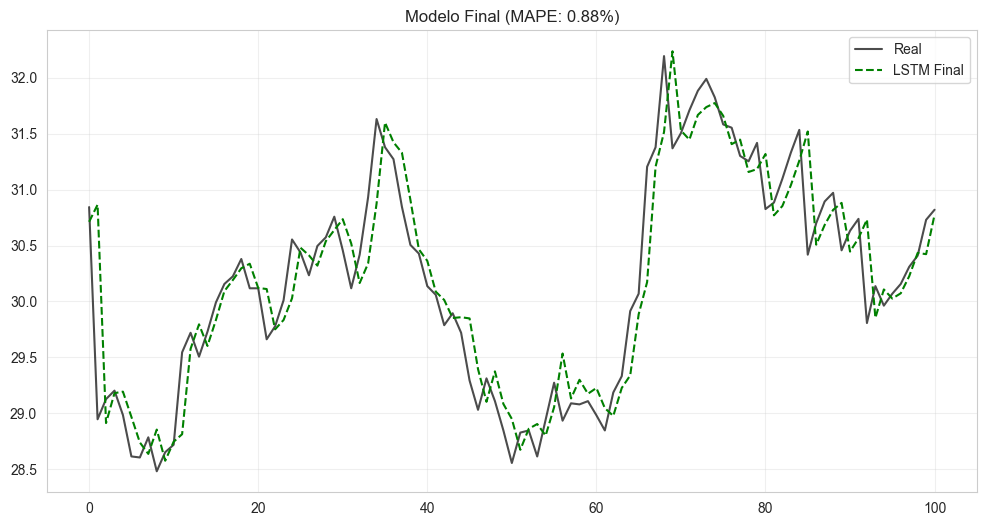

In [25]:
set_seeds(43) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. CONFIGURAÇÕES FINAIS ---
feature_cols_final = ["close", "open"]  
BEST_WINDOW_FINAL = 20                 
USE_SCALER_FINAL = True
HIDDEN_SIZE_FINAL = 119
EPOCHS_FINAL = 400
PATIENCE_FINAL = 20
DROPOUT_FINAL = 0.2181710369026575
LR_FINAL = 0.005295762643270361
NUM_LAYERS_FINAL = 1

print("🚀 INICIANDO TREINO DO MODELO FINAL")
print(f"⚙️ Features: {feature_cols_final} | Janela: {BEST_WINDOW_FINAL}")
print(f"⚙️ Hidden: {HIDDEN_SIZE_FINAL} | LR: {LR_FINAL} | Dropout: {DROPOUT_FINAL}")
print("="*60)

# --- 3. PREPARAR DADOS (Variáveis com sufixo _final) ---
train_loader_final, test_loader_final, scaler_final, target_idx_final = get_dataloaders(
    df, 
    feature_cols=feature_cols_final, 
    target_col='close', 
    lookback=BEST_WINDOW_FINAL, 
    split_ratio=0.8,
    batch_size=16, 
    use_scaler=USE_SCALER_FINAL
)

# --- 4. INSTANCIAR MODELO ÚNICO ---
model_final = LSTMModel(
    input_size=len(feature_cols_final), 
    hidden_size=HIDDEN_SIZE_FINAL, 
    num_layers=NUM_LAYERS_FINAL, 
    dropout=DROPOUT_FINAL
).to(device)

# --- 5. TREINAR ---
metrics_final = train_and_evaluate(
    model_final, 
    train_loader_final, 
    test_loader_final, 
    scaler=scaler_final, 
    target_idx=target_idx_final, 
    epochs=EPOCHS_FINAL, 
    patience=PATIENCE_FINAL, 
    device=device,
    lr=LR_FINAL
)

# --- 6. SALVAR (PERSISTÊNCIA) ---
#nome_arquivo_final = 'modelo_lstm_final_v1.pth'
#torch.save(model_final.state_dict(), nome_arquivo_final)
#print(f"\n💾 Modelo blindado salvo em: {nome_arquivo_final}")

# --- 7. VISUALIZAR RESULTADO ---
print("\ RESULTADO FINAL:")
print("   MAPE: {metrics_final['MAPE']:.4f}%")
print("   RMSE: {metrics_final['RMSE']:.4f}")

plt.figure(figsize=(12, 6))
# Usando as variáveis _final para garantir que estamos plotando o dado certo
plt.plot(metrics_final['y_true'][-150:], label='Real', color='black', alpha=0.7)
plt.plot(metrics_final['y_pred'][-150:], label='LSTM Final', color='green', linestyle='--')
plt.title(f"Modelo Final (MAPE: {metrics_final['MAPE']:.2f}%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()